<a href="https://colab.research.google.com/github/dweizzz/datathon23/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib as plot
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from functools import reduce
import matplotlib.pyplot as plt 

#Dataframes

In [4]:
#Immunization dataframe
df_immunizations = pd.read_csv('Immunizations.csv')
df_immunizations=df_immunizations[['Country','Year','Value']]
df_immunizations=df_immunizations.rename(columns={'Value': 'Immunization'})
df_immunizations

,Country,Year,Immunization
0,Australia,2010,91.6
1,Australia,2011,91.6
2,Australia,2012,91.8
3,Australia,2013,91.0
4,Australia,2014,91.2
...,...,...,...
1841,Peru,2016,88.6
1842,Peru,2017,83.0
1843,Peru,2018,84.0
1844,Peru,2019,88.0


In [10]:
#density physicians
df_physicians = pd.read_csv('Physicians.csv')
df_physicians = df_physicians[df_physicians['Variable'] == 'Practising physicians']
df_physicians = df_physicians[df_physicians['Measure'] == 'Density per 1 000 population (head counts)']
df_physicians=df_physicians[['Country','Year','Value']]
df_physicians = df_physicians.rename(columns={'Value': 'Density Physicians'})
df_physicians

,Country,Year,Density Physicians
876,Australia,2011,3.32
877,Australia,2012,3.31
878,Australia,2013,3.37
879,Australia,2014,3.45
880,Australia,2015,3.51
...,...,...,...
1902,Argentina,2015,3.98
1903,Argentina,2016,3.99
1904,Argentina,2017,3.98
1905,Argentina,2019,4.05


In [11]:
#hospitals dataframe
df_hospitals = pd.read_csv('Hospitals.csv')
df_hospitals.reset_index(inplace=True)  # Reset the index to a simple integer index
df_hospitals=df_hospitals[['index','Country','Year','Variable','Value']]
df_hospitals = df_hospitals.groupby(['Country', 'Year'])['Value'].sum().reset_index()
df_hospitals = df_hospitals.rename(columns={'Value': 'Number Hospitals'})
df_hospitals

,Country,Year,Number Hospitals
0,Australia,2010,3842.85
1,Australia,2011,3842.65
2,Australia,2012,3838.75
3,Australia,2013,3863.11
4,Australia,2014,3724.15
...,...,...,...
382,United States,2015,15631.58
383,United States,2016,15564.03
384,United States,2017,17045.28
385,United States,2018,16869.46


In [16]:
#medium wage dataframe
df_medwage = pd.read_csv('MedianWage.csv')
df_medwage=df_medwage[df_medwage['Series'] == '2021 constant prices and NCU']
df_medwage=df_medwage[['Country','Time','Unit Code','Value']]
df_medwage = df_medwage.rename(columns={'Value': 'Median Wage','Time':'Year'})
df_medwage

,Country,Year,Unit Code,Median Wage
638,Australia,2000,AUD,72061.135996
639,Australia,2001,AUD,72786.112538
640,Australia,2002,AUD,73397.410889
641,Australia,2003,AUD,74395.032884
642,Australia,2004,AUD,76695.189678
...,...,...,...,...
2291,Türkiye,2016,TRY,93505.503471
2292,Türkiye,2017,TRY,91745.768303
2293,Türkiye,2018,TRY,93375.721391
2294,Türkiye,2019,TRY,99520.303235


In [17]:
df_pharm = pd.read_csv('Pharmacists.csv')
df_pharm = df_pharm[df_pharm['Variable'] == 'Practising pharmacists']
df_pharm = df_pharm[df_pharm['Measure'] == 'Number of persons (head counts)']
df_pharm = df_pharm[['Country','Year','COU','Value']]
df_pharm = df_pharm.rename(columns={'Value': 'Number Pharmacists','Time':'Year'})
df_pharm

,Country,Year,COU,Number Pharmacists
0,Australia,2010,AUS,19237.0
1,Australia,2011,AUS,15222.0
2,Australia,2012,AUS,17097.0
3,Australia,2013,AUS,19148.0
4,Australia,2014,AUS,19655.0
...,...,...,...,...
1601,Latvia,2017,LVA,1850.0
1602,Latvia,2018,LVA,1650.0
1603,Latvia,2019,LVA,1613.0
1604,Latvia,2020,LVA,1644.0


#Combining Variable Dataframes

In [18]:
dfs = [df_immunizations,df_physicians, df_hospitals, df_medwage,df_pharm]

#merge all DataFrames into one
all_vars = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs)
all_vars.sort_values('Country')

,Country,Year,Immunization,Density Physicians,Number Hospitals,Unit Code,Median Wage,COU,Number Pharmacists
0,Australia,2011,91.6,3.32,3842.65,AUD,85380.702985,AUS,15222.0
27,Australia,2019,95.0,3.83,2129.78,AUD,86682.471660,AUS,22599.0
26,Australia,2019,94.9,3.83,2129.78,AUD,86682.471660,AUS,22599.0
25,Australia,2019,56.2,3.83,2129.78,AUD,86682.471660,AUS,22599.0
24,Australia,2019,94.9,3.83,2129.78,AUD,86682.471660,AUS,22599.0
...,...,...,...,...,...,...,...,...,...
738,United Kingdom,2012,92.0,2.70,4503.60,GBP,35691.909392,GBR,49731.0
737,United Kingdom,2012,95.0,2.70,4503.60,GBP,35691.909392,GBR,49731.0
736,United Kingdom,2012,73.5,2.70,4503.60,GBP,35691.909392,GBR,49731.0
517,United Kingdom,2020,91.1,3.03,4637.12,GBP,38074.428273,GBR,57218.0


#Linear Regression Model

In [20]:
country_specific = all_vars[all_vars['Country'] == 'Australia']

y = country_specific['Immunization']
X = country_specific[['Year', 'Density Physicians','Number Hospitals','Median Wage','Number Pharmacists']]
X['Density Physicians Sqrt'] = np.sqrt(X['Density Physicians'])
#X['Num_Physicians_Sq'] = country_specific['Num_Physicians'] ** 2
X['Number Hospitals Sqrt'] = np.sqrt(X['Number Hospitals'])

# Add a constant term to the independent variables to represent the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the OLS model
model = sm.OLS(y_train, X_train)

# Train the model using the fit method
results = model.fit()

# Predict values for the test set
y_pred = results.predict(X_test)

summary = results.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:           Immunization   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     4.947
Date:                Sun, 30 Apr 2023   Prob (F-statistic):            0.00539
Time:                        19:20:52   Log-Likelihood:                -24.454
No. Observations:                  22   AIC:                             64.91
Df Residuals:                      14   BIC:                             73.64
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -9

<ipython-input-20-800f7bb8820d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Density Physicians Sqrt'] = np.sqrt(X['Density Physicians'])
<ipython-input-20-800f7bb8820d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Number Hospitals Sqrt'] = np.sqrt(X['Number Hospitals'])


#Calculate Increase Required

In [ ]:
input_goal = 92
input_year
predicted_value = results.predict(sm.add_constant(X[['Year', 'Number Physicians','Number Hospitals','Median Wage','Number Pharmacists', 'Number Physicians Sqrt', 'Number Hospitals Sqrt']]))[0]

# Calculate the change in immunizations needed
change_in_immunizations = goal_value - predicted_value

# Calculate the change in the number of physicians needed
coeff_physicians = results.params['Number Physicians']
coeff_physicians_sqrt = results.params['Number Physicians Sqrt']
change_in_physicians = (change_in_immunizations / coeff_physicians) - ((X_test['Number Physicians'].mean() - np.sqrt(X_test['Number Physicians']).mean() * coeff_physicians_sqrt) / coeff_physicians)

# Calculate the estimated number of physicians required to reach the predicted immunization rate
estimated_physicians = (predicted_value / coeff_physicians) - ((X_test['Number Physicians'].mean() - np.sqrt(X_test['Number Physicians']).mean() * coeff_physicians_sqrt) / coeff_physicians)

print("Current Immunization Expected By",Input_Year)
print(f"To increase the number of immunizations from {predicted_value:.2f} to {goal_value:.2f}, the number of physicians would need to change by {change_in_physicians:.2f}.")
print(f"The estimated number of physicians required to reach the predicted immunization rate is {estimated_physicians:.2f}.")

91.94104556094658
To increase the number of immunizations from 91.94 to 92.00, the number of physicians would need to change by 701751037.44.
The estimated number of physicians required to reach the predicted immunization rate is 700280456.10.


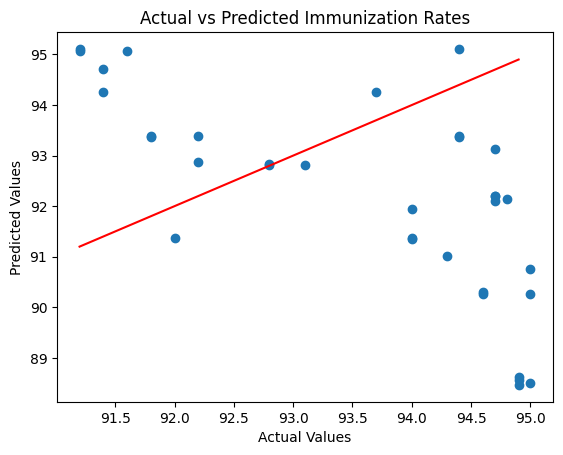

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Immunization Rates')

# Add regression line to plot
x_line = np.arange(min(y_test), max(y_test), 0.1)
y_line = x_line
plt.plot(x_line, y_line, color='red')

plt.show()

In [ ]:
q1 = country_specific.quantile(0.25)
q3 = country_specific.quantile(0.75)
iqr = q3 - q1
outliers = ((country_specific < (q1 - 1.5 * iqr)) | (country_specific > (q3 + 1.5 * iqr))).sum()
print('Outliers in the data:\n', outliers)

Outliers in the data:
 Country           0
Immunization      2
Num_Hospitals     0
Num_Physicians    0
Year              0
dtype: int64


<ipython-input-125-0e1360286543>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = country_specific.quantile(0.25)
<ipython-input-125-0e1360286543>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = country_specific.quantile(0.75)
<ipython-input-125-0e1360286543>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((country_specific < (q1 - 1.5 * iqr)) | (country_specific > (q3 + 1.5 * iqr))).sum()
